In [1]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
from itertools import product
from calc_observables import *

figwidth = 6.224
golden_ratio = 1.61803
figsize = (figwidth, figwidth / golden_ratio)
import matplotlib as mpl
sns.set_style("ticks")
sns.set_palette('colorblind')
mpl.rcParams['figure.figsize'] = figsize
mpl.rcParams['font.sans-serif'] = ['Open Sans']

path = '.\\data\\watts strogatz 3\\'

In [2]:
%matplotlib inline

In [3]:
n_pr = np.load(path+'n_pr.npy', allow_pickle=True)
params = np.load(path+'params.npz')
ps = params['ps']
reps = int(params['reps'])
# k_offblock = params['k_offblock']
k_offblock = params['ks']

In [4]:
tmax = max(map(len, n_pr.flat))  # maximum time of epidemic
n_prnew = np.array([list(xi) + [xi[-1]] * (tmax - len(xi)) for xi in n_pr.ravel()])
n_prnew = n_prnew.reshape((len(ps), len(k_offblock), reps, n_prnew.shape[-2], n_prnew.shape[-1]))

In [5]:
t_lag = 10
nps = len(ps)
nks = len(k_offblock)
n_tot = n_prnew[0, 0, 0, 0].sum()
hcap = n_tot * 30 // 100000
axreps = 2

In [6]:
n_tot

100000

In [11]:
n_prnew = n_prnew * 1e6 / n_tot

In [8]:
dflist = [pd.DataFrame({'S': n_pr[ip, ik, n][:, 0] * 1e6 / n_tot, 'E': n_pr[ip, ik, n][:, 1] * 1e6 / n_tot,
                        'I': n_pr[ip, ik, n][:, 2] * 1e6 / n_tot, 'R': n_pr[ip, ik, n][:, 3] * 1e6 / n_tot,
                        't': np.arange(n_pr[ip, ik, n].shape[0]), 'k': k, 'p': p, 'n': n, 'id': i})
          for i, ((ip, p), (ik, k), n) in enumerate(product(enumerate(ps), enumerate(k_offblock), range(reps)))]

df = pd.concat(dflist, ignore_index=True)

In [9]:
gb = df.groupby('id')
df['New cases'] = gb.I.diff() + gb.R.diff()
df['New cases'] = df['New cases'].fillna(0)

In [10]:
# del df['Mean new cases']
window = 7
def add_rolling_mean(x):
    x['Rolling new cases'] = x['New cases'].rolling(window, center=True).mean().fillna(0)
    return x

df = df.groupby('id').apply(add_rolling_mean)

In [11]:
def add_shifted_date(x):
    x['Shifted t'] = x.t - x.loc[x['Rolling new cases'] >= 1].t.min()
    return x

df = df.groupby('id').apply(add_shifted_date)

(0.0, 100.0)

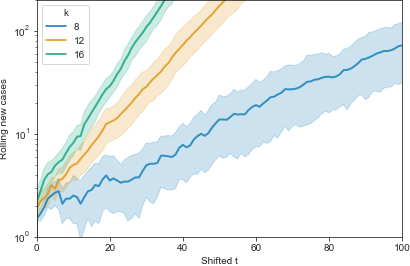

In [12]:
sns.lineplot(data=df.loc[df.p == ps[-1]].loc[df.k.isin(np.arange(8, 19, 4))], hue='k', x='Shifted t', y='Rolling new cases',
             palette='colorblind', # style='n',
             alpha=0.75, markers=False, dashes=False, legend='brief', linewidth=2)
plt.yscale('log')
plt.ylim(1, 2e2)
plt.xlim(0, 100)

In [13]:
df['Cumulative cases'] = df.groupby('id')['New cases'].cumsum()

(0.0, 100.0)

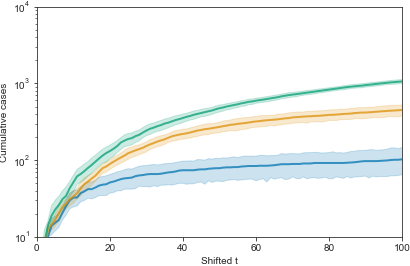

In [14]:
sns.lineplot(data=df.loc[df.p == ps[0]].loc[df.k.isin(np.arange(8, 19, 4))], hue='k', x='Shifted t', y='Cumulative cases',
             palette='colorblind', # style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
plt.yscale('log')
plt.ylim(1e1, 1e4)
plt.xlim(0, 100)

In [15]:
def add_R(x, tlag=10):
    active = x['Rolling new cases'].values.astype(float)
    R = np.zeros_like(active)
    R[tlag:] = np.divide(active[tlag:], active[:-tlag], where=active[:-tlag]>0, out=np.zeros_like(R[tlag:]))
    x['R'] = R
    return x

df = df.groupby('id').apply(add_R)

(0.0, 100.0)

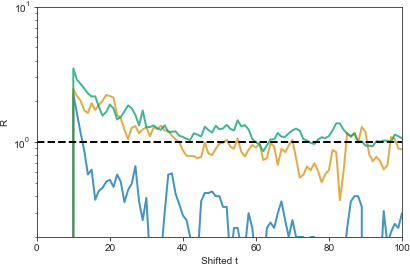

In [16]:
sns.lineplot(data=df.loc[df.p == ps[0]].loc[df.k.isin(np.arange(8, 19, 4))], hue='k', x='Shifted t', y='R',
             palette='colorblind', ci=None,# style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
plt.yscale('log')
plt.plot([0, 200], [1, 1], 'k--', label='$R = 1$', lw=2)
plt.ylim(0.2, 10)
plt.xlim(0, 100)

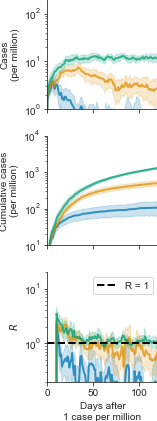

In [17]:
w = 0.4 * figwidth
fig, axs = plt.subplots(nrows=3, ncols=1, sharey=False, sharex=True, figsize=(w, 4/golden_ratio*w))
ind = 0
plt.sca(axs[0])
# plt.title('Cases (per mil)')
sns.lineplot(data=df.loc[df.p == ps[ind]].loc[df.k.isin(np.arange(8, 19, 4))], hue='k', x='Shifted t', y='Rolling new cases',
             palette='colorblind', # style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
plt.ylim(1, 2e2)
plt.ylabel('')
plt.ylabel('Cases\n(per million)')
plt.yscale('log')
sns.despine()


plt.sca(axs[1])
# plt.title('Cumulative cases (per mil)')
sns.lineplot(data=df.loc[df.p == ps[ind]].loc[df.k.isin(np.arange(8, 19, 4))], hue='k', x='Shifted t', y='Cumulative cases',
             palette='colorblind', # style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
plt.ylabel('Cumulative cases\n(per million)')
# plt.ylabel('')
plt.ylim(1e1, 1e4)
plt.yscale('log')
sns.despine()


plt.sca(axs[2])
# plt.title('Reproduction number')
sns.lineplot(data=df.loc[df.p == ps[ind]].loc[df.k.isin(np.arange(8, 19, 4))], hue='k', x='Shifted t', y='R',
             palette='colorblind', # style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
plt.xlim(0, 120)
plt.ylim(0.2, 20)
plt.plot([0, 200], [1, 1], 'k--', label='R = 1', lw=2)
plt.yscale('log')
plt.ylabel('$R$')
# plt.xlabel('')
# plt.ylabel('')
plt.xlabel('Days after\n1 case per million')
plt.legend(loc='upper right')
sns.despine()
plt.tight_layout()

In [13]:
mean_infected = n_prnew[..., 2].mean(axreps)
std_infected = n_prnew[..., 2].std(axreps, ddof=1) #/ np.sqrt(reps)  # std of the mean of infected

mean_recovered = n_prnew[..., -1].mean(axreps)
std_recovered = n_prnew[..., -1].std(axreps, ddof=1) #/ np.sqrt(reps)
cum_infected = mean_recovered + mean_infected
std_cuminf = np.sqrt(std_recovered**2 + std_infected**2)

newcases = np.zeros_like(cum_infected)
newcases[..., 1:] = cum_infected[..., 1:] - cum_infected[..., :-1]
std_newcases = np.zeros_like(newcases)
std_newcases[..., 1:] = np.sqrt(std_cuminf[..., 1:]**2 + std_cuminf[..., :-1]**2)

r_eff = np.zeros_like(mean_infected)
r_eff[..., t_lag:] = np.divide(newcases[..., t_lag:], newcases[..., :-t_lag], where=newcases[..., :-t_lag]>0,
                               out=np.zeros_like(r_eff[..., t_lag:]))
# r_eff = np.ma.array(r_eff, mask=(newcases[..., :-t_lag]==0))
std_r = np.zeros_like(r_eff)
std_r[..., t_lag:] = np.sqrt((std_newcases[..., t_lag:] / newcases[..., :-t_lag])**2 + (newcases[..., t_lag:] / newcases[..., :-t_lag]**2 *
                                                                      std_newcases[..., :-t_lag])**2)

C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


In [14]:
def plot_errorshade(x, y, yerr, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    plot, = ax.plot(x, y, **kwargs)
    shade = ax.fill_between(x, y - yerr, y + yerr, color=plot.get_color(), alpha=0.5)
    return plot


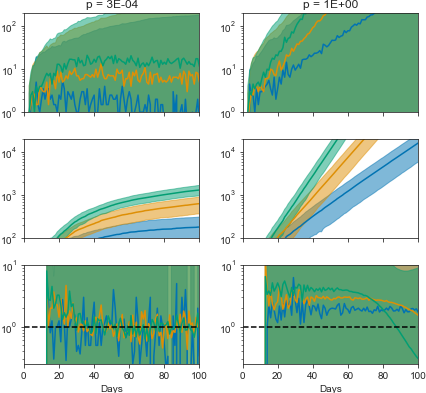

In [14]:
w = figwidth
fig, axss = plt.subplots(nrows=3, ncols=2, sharey=False, sharex=True, figsize=(w, 1.5/golden_ratio*figwidth))
inds = [3, -1]
unlabeled = True

for ind, axs in zip(inds, axss.T):
    axs[0].set_title('p = {:.0E}'.format(ps[ind]))
    # axs[0].set_title('Number of non-local contacts m = {:.1f}'.format(ps[ind]))
    if unlabeled:
#         axs[2].set_ylabel('Reproduction number')
#         axs[0].set_ylabel('Active cases per million')
#         axs[1].set_ylabel('Cumulative cases per million')
        unlabeled = False

#     
#     axs[0].set_ylim(1, mean_infected[ind].max())
    axs[0].set_ylim(1, 2e2)
    axs[1].set_ylim(1e2, 2e4)
    axs[2].set_ylim(0.25, 10)
    axs[1].set_yscale('log')
    axs[0].set_yscale('log')
    axs[2].set_yscale('log')
    axs[2].set_xlabel('Days since 100 active cases per million')
    axs[2].set_xlabel('Days')


    # axs[0].plot([0, tmax], [hcap, hcap])
    x = range(tmax)

    for i, r in enumerate(r_eff[ind]):
        if k_offblock[i] > 6 and k_offblock[i] < 20 and i % 2 == 0:
            label = '$k =$ {:.1f}'.format(k_offblock[i])
            plot_errorshade(x, newcases[ind, i], std_newcases[ind, i], ax=axs[0], label=label)
            plot_errorshade(x, cum_infected[ind, i], std_cuminf[ind, i], ax=axs[1], label='_'+label)
            plot_errorshade(x, r, std_r[ind, i], label='_'+label, ax=axs[2])

    axs[2].plot([0, tmax], [1, 1], 'k--', label='$R = 1$')

    if ind == 1:
        axs[0].legend(loc='best')
        axs[2].legend()
    for i in range(3):
#         axs[i].set_xlim(1, max(np.argmax(mean_infected[0]<1, axis=1)))
        axs[i].set_xlim(0, 100)


plt.tight_layout()
#for ax in axs:
# plt.savefig('newsimulations.svg')

In [15]:
peaks = mean_infected.max(axis=-1)
argpeaks = mean_infected.argmax(axis=-1)
std_peaks = np.take_along_axis(std_infected, np.expand_dims(argpeaks, axis=-1), axis=-1).squeeze(axis=-1) #/ 1e6

In [16]:
peaksrel = peaks / n_tot
peaksrel.min()

1e-05

(0.0001, 1)

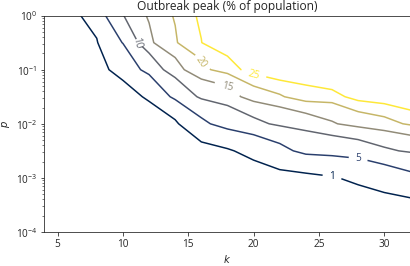

In [18]:
cs = plt.contour(k_offblock, ps, peaks / n_tot * 100, cmap='cividis', levels=[1, 5, 10, 15, 20, 25])


plt.clabel(cs, fmt='%1.0f')
plt.xlabel('$k$')
plt.title('Outbreak peak (% of population)')
plt.ylabel('$p$')
plt.xlim(4)
# plt.plot(2 * k, 0.1 / (2 * k*0.02))
plt.yscale('log')
plt.ylim(1e-4, 1)
#plt.savefig('contour_peak.svg', dpi=600, bbox_inches='tight', pad_inches=0)

(1, 2250.085837454252)

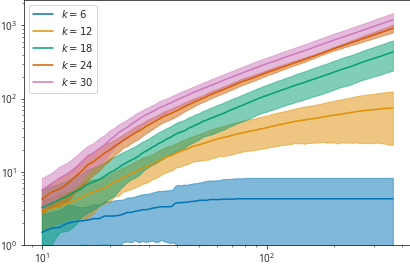

In [19]:
tmin = 10
tmax = 365
for i in range(2, nks, 3):
    plot_errorshade(np.arange(tmin, tmax), cum_infected[0, i, tmin:tmax], std_cuminf[0, i, tmin:tmax], label='$k = {}$'.format(k_offblock[i]))
    
plt.loglog()
plt.legend()
plt.ylim(1)

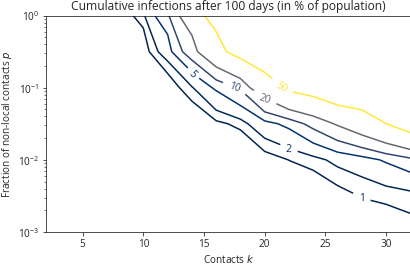

In [20]:
#plt.yscale('log')
#plt.xlim(4, k_offblock.max())
cs = plt.contour(k_offblock, ps, cum_infected[..., 100] / n_tot * 100, cmap='cividis', levels=[1, 2, 5, 10, 20, 50])
plt.clabel(cs, fmt='%1.0f')
plt.xlabel('Contacts $k$')
plt.title('Cumulative infections after 100 days (in % of population)')
plt.ylabel('Fraction of non-local contacts $p$')
plt.ylim(1e-3)
plt.yscale('log')
# plt.plot(2 * k, 2 * c / kr/ n_tot * 100)


In [18]:
ps, k_offblock, peaks.shape

(array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
        1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
        1.00000000e-01, 3.16227766e-01, 1.00000000e+00]),
 array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32],
       dtype=int64),
 (11, 16))

In [29]:
indp = -2
indk = 12
peaks[indp, indk] / n_tot * 100, cum_infected[indp, indk, -1] / n_tot * 100,  ps[indp], k_offblock[indk]  # peak with before-LD parameters

(45.0515, 99.49755, 0.31622776601683794, 26)

In [27]:
indp = 1
indk = 2
peaks[indp, indk] / n_tot * 100, cum_infected[indp, indk, -1] / n_tot * 100,  ps[indp], k_offblock[indk]  # peak with before-LD parameters

(0.0015500000000000002, 0.0057, 3.1622776601683795e-05, 6)

In [24]:
indp = 7
indk = 5
peaks[indp, indk] / n_tot * 100, cum_infected[indp, indk, -1] / n_tot * 100,  ps[indp], k_offblock[indk]  # peak with before-LD parameters

(1.3433, 9.772949999999998, 0.03162277660168379, 12)

NameError: name 'ticker' is not defined

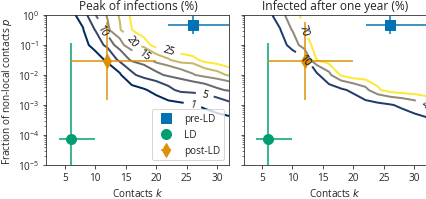

In [31]:
tmax = 365
manual = 0
w = figwidth
lw = 2
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, tight_layout=True, figsize=(w, 0.8*w/golden_ratio))


medianp1 = 7.511228309869421e-05
lowerp1 = 1.2903750564053015e-07
upperp1 = 0.11578674876657949

medianp2 = 0.4830784091511589
lowerp2 = 0.22608065801071853
upperp2 = 0.9374843493989065

medianp3 = 0.029880368815957712
lowerp3 = 0.0014147786947638868
upperp3 = 0.5982238362735793

plt.sca(axs[0])
# plt.xlim(5, 22)


plt.xlim(2, 32)
plt.ylim(1e-5, 1)
# plt.arrow(14.5, 0.35, 1, 0.05, length_includes_head=True, color='r', width=0.01, head_width=0.05, overhang=5, label='pre-LD')

plt.yscale('log')
cs = plt.contour(k_offblock, ps, peaks / n_tot * 100, cmap='cividis', levels=[0, 1, 5, 10, 15, 20, 25], linewidths=2)
plt.clabel(cs, fmt='%1.0f', colors='k', manual=manual)

plt.errorbar([26], [medianp2], fmt='s', c='C0', ms=10, label='pre-LD', xerr=((4,), (6,)), 
             yerr=((medianp2-lowerp2, ), (upperp2-medianp2,)))

# plt.plot([20], [0.09], 'r', linestyle='none', marker='$\\nearrow$', label='pre-LD', ms=15)
plt.errorbar([6], [medianp1], fmt='o', ms=10, label='LD', yerr=((medianp1-lowerp1, ), (upperp1-medianp1,)), c='C2',
             xerr=((2, ), (4,)))
plt.errorbar([12], [medianp3], fmt='d', ms=10, label='post-LD', yerr=((medianp3-lowerp3, ), (upperp3-medianp3,)),
            xerr=((6, ), (8,)), c='C1')
plt.xlabel('Contacts $k$')
plt.title('Peak of infections (%)')
plt.ylabel('Fraction of non-local contacts $p$')
# plt.plot([0, 32], [0, 0.66], 'g--')

# plt.legend(loc='upper center', bbox_to_anchor=(1., -0.4), ncol=3)
plt.legend()

plt.sca(axs[1])
# plt.plot([20], [0.09], 'r', linestyle='none', marker='$\\nearrow$', label='pre-LD', ms=15)
cs = plt.contour(k_offblock, ps, cum_infected[..., tmax] / n_tot * 100, cmap='cividis', levels=[0, 10, 40, 70],
                 linewidths=2)
plt.clabel(cs, fmt='%1.0f', colors='k', manual=manual)

plt.errorbar([26], [medianp2], fmt='s', ms=10, label='pre-LD', xerr=((4,), (6,)), c='C0',
             yerr=((medianp2-lowerp2, ), (upperp2-medianp2,)))
plt.errorbar([6], [medianp1], fmt='o', ms=10, label='LD', yerr=((medianp1-lowerp1, ), (upperp1-medianp1,)), c='C2',
             xerr=((2, ), (4,)))
plt.errorbar([12], [medianp3], fmt='d', ms=10, label='post-LD', yerr=((medianp3-lowerp3, ), (upperp3-medianp3,)),
            xerr=((6, ), (8,)), c='C1')
plt.xlabel('Contacts $k$')
plt.title('Infected after one year (%)')
axs[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
axs[1].xaxis.set_minor_formatter(ticker.FormatStrFormatter('%0.0f'))
label_axes(fig)
# plt.show()
# plt.savefig('./figures/paramscan_log_updated.svg', bbox_inches='tight', pad_inches=0)